In [1]:
!git clone https://github.com/deepseek-ai/Janus
%cd Janus
!pip install -e .

fatal: destination path 'Janus' already exists and is not an empty directory.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=15950 sha256=d13316e1ded91f8ff219547dae6d4e8cedd18afff389d6c6f8aa7c4c7cd08070
  Stored in directory: /tmp/pip-ephem-wheel-cache-eo9citb_/wheels/04/ee/d6/76a460ef4080a263aa86cc3fdbb1c5bb29f559fbd8155d1c83
Successfully built janus
  Attempting uninstall: janus
    Found existing installation: janus 1.0.0
    Uninstalling janus-1.0.0:
      Successfully uninstalled janus-1.0.0


In [2]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [3]:
# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-7B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
conversation = [
    {
        "role": "<|User|>",
        "content": f"\n What is this place. Tell me it's history.",
        "images": ['/content/colosseum.jpg'],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

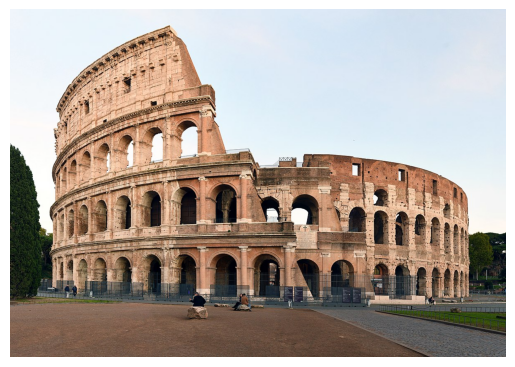

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('/content/colosseum.jpg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [6]:
# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: What is this place. Tell me it's history.

<|Assistant|>: This is the Colosseum, an ancient amphitheater located in Rome, Italy. It was built in the 1st century AD and was used for gladiatorial contests and public spectacles. The Colosseum is one of the most iconic landmarks in Rome and a testament to the engineering and architectural skills of the ancient Romans.
